In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy
import pickle
from glob import glob
from typing import Any, Dict, List, Tuple, Union
import pandas as pd

In [7]:
prediction = pd.read_csv('outputs1ep_train.csv')

In [8]:
pickles = ["./new_train/new_train/12028.pkl", "./new_train/new_train/17520.pkl", "./new_train/new_train/17910.pkl", "./new_train/new_train/26898.pkl"]

for pkl_path in pickles:
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)

In [9]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data

val_dataset = ArgoverseDataset(data_path="./new_train/train_subset")


In [10]:
batch_sz = 4

def train_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'][scene['track_id'][:,0,0]==scene['agent_id'],:,:]]) for scene in batch]
    out = [numpy.dstack([scene['p_out'][scene['track_id'][:,0,0]==scene['agent_id'],:,:]]) for scene in batch]
    inp = torch.Tensor(inp)
    out = torch.Tensor(out)
    idx = [numpy.dstack([scene['scene_idx']]) for scene in batch]

    return [inp, out, idx]

val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=train_collate, num_workers=0)


In [11]:
import matplotlib.pyplot as plt
import random

agent_id = 0

def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out, idx = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(20, 10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    fig.suptitle("Visualization of four different trajectories")
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        predicted_x = []
        predicted_y = []
        actual_x = []
        actual_y = []
        for j in range(out.size(2)):
            actual_x.append(out[i,:,j,0])
            actual_y.append(out[i,:,j,1])
        # first two feature dimensions are (x,y) positions
        for j in range (1, len(prediction.columns), 2):
            predicted_x.append(prediction.loc[prediction['ID'] == idx[i][0][0][0]]["v"+str(j)])
            predicted_y.append(prediction.loc[prediction['ID'] == idx[i][0][0][0]]["v"+str(j+1)])
            
        axs[i].scatter(actual_x, actual_y, label="Actual Trajectory")
        axs[i].scatter(predicted_x, predicted_y, label="Predicted Trajectory")
        leg = axs[i].legend()

In [12]:
for i_batch, sample_batch in enumerate(val_loader):
    inp, out, idx = sample_batch
    show_sample_batch(sample_batch)

In [13]:
prediction.loc[prediction['ID'] == 13337]

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60


In [47]:
import numpy as np
import re

In [50]:
loss_steps = pd.read_csv('loss_steps.txt', sep=",").T
loss_steps = loss_steps.reset_index()
loss_steps = loss_steps.rename(columns={'index': 'loss'})
loss_steps

,loss
0,16.81099510192871
1,15.4517183303833
2,20.09018325805664
3,20.479185104370117
4,19.501070022583008
...,...
14189,2.607841730117798
14190,3.095977544784546
14191,3.5897161960601807
14192,1.6190322637557983


In [53]:
list(loss_steps.get('loss').values)

['16.81099510192871',
 '15.4517183303833',
 '20.09018325805664',
 '20.479185104370117',
 '19.501070022583008',
 '26.66968536376953',
 '17.720163345336914',
 '25.303787231445312',
 '15.830249786376953',
 '39.24130630493164',
 '26.506563186645508',
 '24.55872917175293',
 '20.49296760559082',
 '19.82572364807129',
 '33.16999053955078',
 '16.508987426757812',
 '16.72706413269043',
 '11.796303749084473',
 '14.046285629272461',
 '19.40189552307129',
 '17.57903480529785',
 '19.750709533691406',
 '25.082719802856445',
 '20.2585506439209',
 '22.121177673339844',
 '20.74077796936035',
 '10.041243553161621',
 '11.200822830200195',
 '24.124589920043945',
 '15.940937042236328',
 '29.949085235595703',
 '27.110082626342773',
 '19.264925003051758',
 '13.278438568115234',
 '19.330951690673828',
 '20.61149024963379',
 '24.10716438293457',
 '26.03370475769043',
 '20.82240104675293',
 '29.07966423034668',
 '25.4677677154541',
 '37.390830993652344',
 '18.20668601989746',
 '23.92058563232422',
 '19.09346961

In [67]:
r = re.compile(".*([.]1)$")
list(filter(r.match, list(loss_steps.get('loss').values)))

['3.6601977348327637.1', '2.62221097946167.1']

In [46]:
np.count_nonzero(pd.read_csv('loss_steps.txt', sep=",").columns.str.contains('.1'))

11338

In [68]:
loss_steps = loss_steps[~loss_steps['loss'].str.contains('3.6601977348327637.1')]
loss_steps = loss_steps[~loss_steps['loss'].str.contains('2.62221097946167.1')]
loss_steps

,loss
0,16.81099510192871
1,15.4517183303833
2,20.09018325805664
3,20.479185104370117
4,19.501070022583008
...,...
14189,2.607841730117798
14190,3.095977544784546
14191,3.5897161960601807
14192,1.6190322637557983


In [69]:
loss_steps['loss'] = loss_steps['loss'].astype(float)

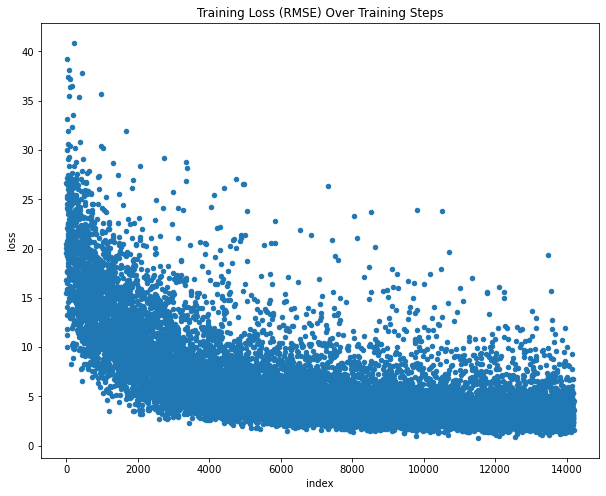

In [79]:
loss_steps.reset_index().plot.scatter(x='index', y='loss', figsize=[10,8], title='Training Loss (RMSE) Over Training Steps')